# LaserBeam Attack
The main objective of this notebook is to present an attack on a neural network using a laser.
LaserBeam attack presented in this 
[paper](https://openaccess.thecvf.com/content/CVPR2021/papers/Duan_Adversarial_Laser_Beam_Effective_Physical-World_Attack_to_DNNs_in_a_CVPR_2021_paper.pdf) is based on the following idea. 
Image of the laser beam is generated and then added to the attacked image. 
Laser beam is described by four parameters: wavelength(nanometers), angle(rad), bias(px) and width(px). 
During the attack those parameters are optimised in order to achievie prediction change. 


In [2]:
import os 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mimg
from PIL import Image
from art.attacks.evasion.laser_attack.laser_attack import \
    LaserBeamAttack, LaserBeam, LaserBeamGenerator, ImageGenerator
from art.attacks.evasion.laser_attack.utils import add_images

### Define minimal and maximal laser beam properties and create generator responsible for generation adversarial objects

minimal:
- wavelength: 380 nm
- angle: 0 rad
- bias: 0 px
- width: 0px

maximal:
- wavelength: 780 nm
- angle: pi rad
- bias: 32 px
- width: 32 px

In [3]:
min_lb = LaserBeam.from_array([380, 0, 0, 0])
max_lb = LaserBeam.from_array([780, 3.14, 32, 32])
lb_gen = LaserBeamGenerator(min_lb, max_lb, 0.2)

### Create instance of image generator that is responsible for generation of images with adversarial objects on them

In [4]:
img_gen = ImageGenerator()

In [5]:
generated_img = img_gen.generate_image(lb_gen.random(), (64,32,3))

### Image of random laser beam based on prevoius parameters

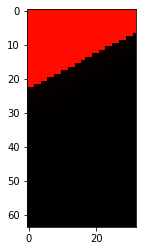

In [6]:
plt.imshow(generated_img)

## Cifar10 model will be used to present the attack

### Constants

In [7]:
CLASSES = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
]

In [8]:
IMAGE_SIZE = (32, 32)
IMAGE_SHAPE = (*IMAGE_SIZE, 3)
REAL_CLASS = 9

In [9]:
CLASSES[REAL_CLASS]

'truck'

### Helper functions

In [10]:
def rescale_image(image: np.ndarray, desired_size=IMAGE_SIZE):
	image_uin8 = (image*255).astype(np.uint8)
	img = Image.fromarray(image_uin8).resize(IMAGE_SIZE)
	return np.array(img)/255

In [11]:
def load_image(seeken_class):
	idx = np.where(y_test == seeken_class)[0][0]
	return x_test[idx]

In [12]:
def predict_image_class(image, model):
	image_expanded = np.expand_dims(image, 0)
	return model.predict(image_expanded)
	

In [13]:
def plot_results(
	real_image_and_class, 
	adversarial_image_and_class, 
	figsize=IMAGE_SIZE, 
	classes=CLASSES
):
	figure = plt.figure(figsize=figsize)
	for i, record in enumerate(
		[
			(*real_image_and_class, "Real"), 
			(*adversarial_image_and_class, "Adversarial"),
			(load_image(adversarial_image_and_class[1]), adversarial_image_and_class[1], "Confused with:")
		]
	):
		image, image_class_number, title = record
		image_class = classes[image_class_number]
		figure.add_subplot(1,3, i+1)
		plt.imshow(image)
		plt.title(title, fontsize=32)
		plt.xlabel(image_class, fontsize=32)
	plt.show()


### Prepare dataset and model

In [14]:
from tensorflow.keras.datasets import cifar10

In [15]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train/255.
x_test = x_test/255.

In [16]:
model = tf.keras.models.load_model("../cifar10/neptune/cifar10v2.h5")

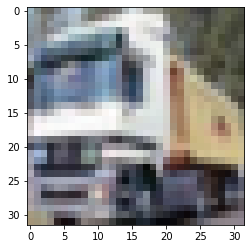

In [17]:
plt.imshow(x_train[1])

In [18]:
truck = x_train[1]

In [19]:
prediction = predict_image_class(truck, model)

In [20]:
predicted_class = prediction.argmax()

In [21]:
CLASSES[predicted_class]

'truck'

### Check correctness of the prediction

In [22]:
predicted_class == REAL_CLASS

True

## Attack

In [23]:
model.channels_first = False

In [24]:
attack = LaserBeamAttack(
    estimator=model, 
    iterations=50,
    max_laser_beam=(780, 3.14, 32, 32)
)

In [36]:
adversarial_images = attack.generate(
	x=np.expand_dims(truck, axis=0)
)

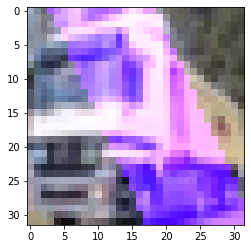

In [37]:
plt.imshow(adversarial_images[0])

In [38]:
adv_pred = model.predict(np.expand_dims(adversarial_images[0], 0))

## Result: Success! Truck confused with bird!

In [39]:
CLASSES[adv_pred.argmax()]

'bird'

## Generate laser parameters instead of images

In [40]:
adversarial_laser, adversarial_class = attack.generate_parameters(
	x=np.expand_dims(truck, axis=0)
)[0]

In [41]:
adversarial_laser_image = ImageGenerator().generate_image(adversarial_laser, shape=IMAGE_SHAPE)

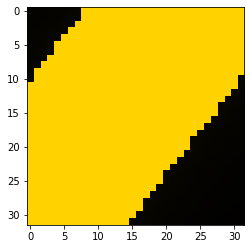

In [42]:
plt.imshow(adversarial_laser_image)

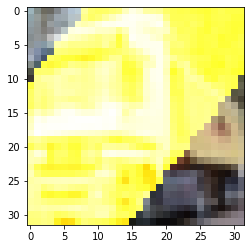

In [43]:
adversarial_image = add_images(truck, adversarial_laser_image)
plt.imshow(adversarial_image)

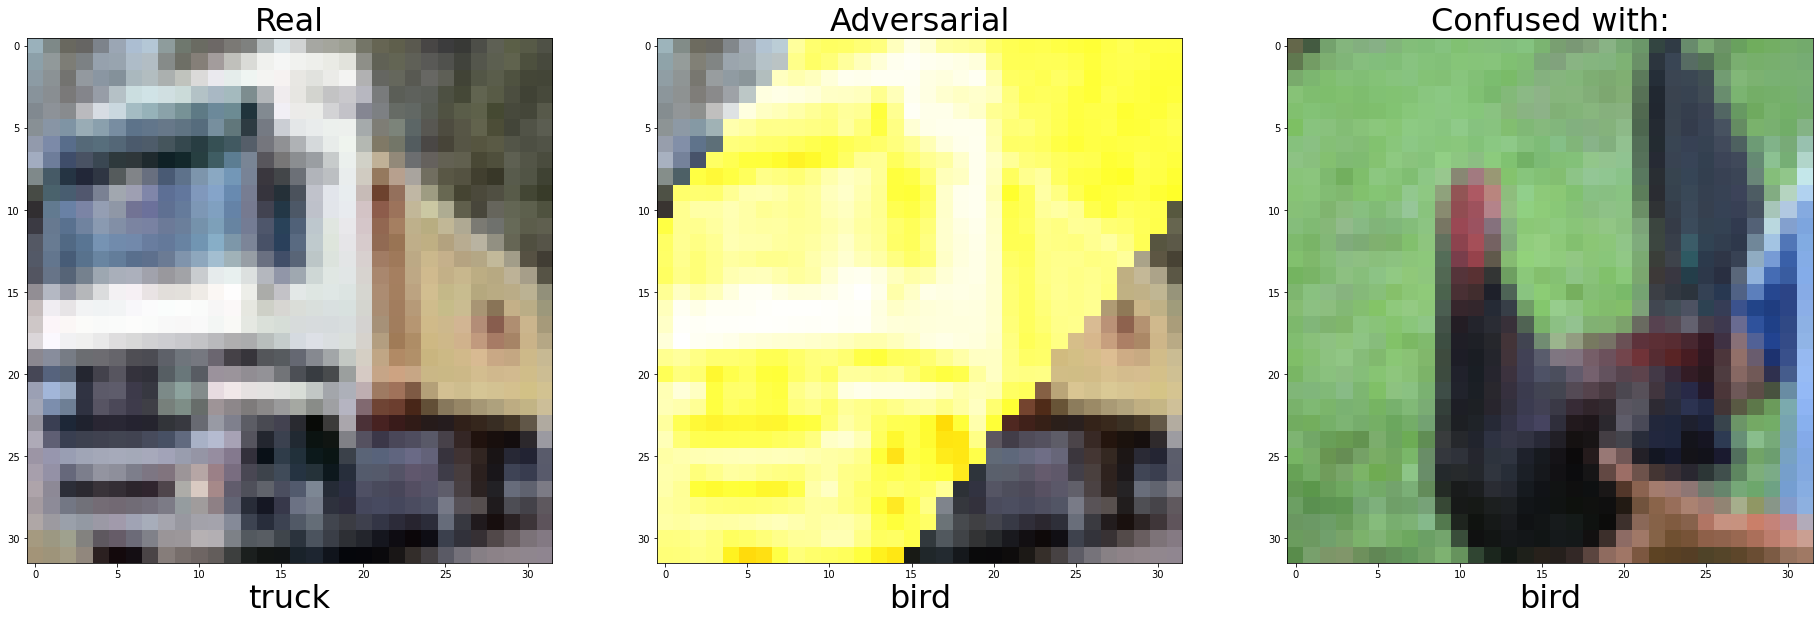

In [44]:
plot_results(
	(truck, predicted_class),
	(adversarial_image, adversarial_class)
)